In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
os.chdir('/')

In [ ]:
print('Data size:', os.path.getsize('/drive/My Drive/netology_hw/final_proj_2/netology_final_proj_data.zip') / 1024 ** 2, 'MB')

Data size: 1037.8956136703491 MB


In [ ]:
import os
os.chdir('/content')

In [ ]:
!unzip -qo '/drive/My Drive/netology_hw/final_proj_2/netology_final_proj_data.zip'

In [ ]:
import os
os.chdir('/')

In [ ]:
!ls content/data/train_recognition

images	images_for_test  labels.csv  val.csv


In [ ]:
!pip install -q python-Levenshtein
!pip install -q albumentations==0.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 KB 8.6 MB/s eta 0:00:00


# Импорт

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
import numpy as np
import editdistance
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms
import os
import random
from PIL import Image, ImageDraw
import json
from IPython.display import clear_output

from matplotlib import pyplot as plt
import random

from natsort import natsorted
import tqdm
import Levenshtein

# 1. Разделим трейн датасет на обучающую и валидационную подвыборки


In [ ]:
def prepare_text(text):
    '''general text preparation'''
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#engine='python', usecols=['Date', 'String'])

import regex as re
labels = pd.read_csv('content/data/train_recognition/labels.csv', sep='^([^,]+),',).astype(str)
labels = labels.dropna()
labels['text'] = labels['text'].apply(lambda x: prepare_text(x))

labels = labels.sample(frac=1).reset_index(drop=True)

labels_train = labels

#labels_train, labels_val = train_test_split(labels, test_size=0.1, random_state=seed)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
labels_train

,Unnamed: 0,file_name,text
0,nan,000110860.jpg,Procambium
1,nan,000101671.jpg,МЭТРОМ
2,nan,4722.png,Eastling
3,nan,000141669.jpg,Сымпровизировавшую-острейшей
4,nan,000077903.jpg,m
...,...,...,...
244642,nan,000045800.jpg,Pyramided
244643,nan,000218253.jpg,А+щ!Ыъж10Т1
244644,nan,000021195.jpg,Выбреет
244645,nan,000097072.jpg,КАЧКАНАРСКОЙ-


In [ ]:
lens_ = [len(i) for i in labels_train.text]
t_f_matrix = [True if i < 32 else False for i in lens_ ]

In [ ]:
labels_train = labels_train[t_f_matrix]

In [ ]:
labels_train

,Unnamed: 0,file_name,text
0,nan,000110860.jpg,Procambium
1,nan,000101671.jpg,МЭТРОМ
2,nan,4722.png,Eastling
3,nan,000141669.jpg,Сымпровизировавшую-острейшей
4,nan,000077903.jpg,m
...,...,...,...
244642,nan,000045800.jpg,Pyramided
244643,nan,000218253.jpg,А+щ!Ыъж10Т1
244644,nan,000021195.jpg,Выбреет
244645,nan,000097072.jpg,КАЧКАНАРСКОЙ-


In [ ]:
!cp -r "/drive/MyDrive/Colab_Notebooks/mmocr/images_for_test" "content/data/train_recognition"

In [ ]:
os.makedirs("content/data/train_recognition/images_for_test_2/1")

In [ ]:
!cp -r "content/data/train_recognition/images_for_test" "content/data/train_recognition/images_for_test_2/1"

In [ ]:
import os
os.chdir('/')

In [ ]:
# Подсчет std и mean на тестовой выборке для правильной аугментации данных

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

data_path = 'content/data/train_recognition/images_for_test_2'

transform_img = transforms.Compose([
    transforms.Resize((64,256)),
    transforms.ToTensor(),
])

image_data = torchvision.datasets.ImageFolder(
  root=data_path, transform=transform_img
)

batch_size = 2

loader = DataLoader(
  image_data, 
  batch_size = batch_size, 
  num_workers=1)

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.8138, 0.8132, 0.8137]) tensor([0.2443, 0.2459, 0.2431])


In [ ]:
labels_val = pd.read_csv('content/data/train_recognition/val.csv', sep='^([^,]+),',).astype(str)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
labels_val

,Unnamed: 0,file_name,text
0,nan,(1_0)_2nd_l_crop.png,МИНИСТЕРСТВО
1,nan,(1_3)_2nd_l_crop.png,ФЕДЕРАЦИИ
2,nan,(1_7)_2nd_l_crop.png,УПРАВЛЕНИЮ
3,nan,(1_8)_2nd_l_crop.png,ГОСУДАРСТВЕННЫМ
4,nan,(1_10)_2nd_l_crop.png,(РОСИМУЩЕСТВО)
...,...,...,...
1124,nan,(114_4)_2nd_l_crop.png,Номера
1125,nan,(114_8)_2nd_l_crop.png,п/п
1126,nan,(114_20)_2nd_l_crop.png,ляров
1127,nan,(114_22)_2nd_l_crop.png,(прописью)


In [ ]:
data_set = 'netology_final_proj_data'
width_test = 256
height_test = 64
bs_test = 256 #batch size
ne_test = 30
lr_test = 0.001 # was 0.001

In [ ]:
#def process_image(img, n_w=256, n_h=64):
def process_image(img, n_w=width_test, n_h=height_test):
    #img = np.array(img, dtype='uint8')
    w, h,_ = img.shape
    new_w = n_h
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    if w < n_h:
        add_zeros = np.full((n_h-w, h,3), 0)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < n_w:
        add_zeros = np.full((w, n_w-h,3), 0)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > n_w or w > n_h:
        dim = (n_w,n_h)
        img = cv2.resize(img, dim)

    return img

def replace_black_to_white(image):
    brown_lo = np.array([0,0,0])
    brown_hi = np.array([0,0,0])

    # Mask image to only select browns
    mask = cv2.inRange(image,brown_lo,brown_hi)

    # Change image to red where we found brown
    image[mask>0] = (255,255,255)
    return image

In [ ]:
def get_cer(list_1, list_2):
  error_chars = 0
  for i,k in zip(list_1, list_2):
    error_chars += (editdistance.eval(i, k) / len(k))
  return error_chars / eval_df.shape[0]

def lev_ratio_func(text_1, text_2):
    lev_d = Levenshtein.distance(text_1, text_2)
    lev_ratio = (len(text_1) + len(text_2) - lev_d) / (len(text_1)+len(text_2))
    return lev_ratio

def lev_perc_func(text_1, text_2):
    lev_d = Levenshtein.distance(text_1, text_2)
    max_len = max(len(text_1),len(text_2))
    lev_ratio = (max_len - lev_d) / max_len
    return lev_ratio

def get_mean_levenshtein_score(list_1, list_2):
    lev_scores = []
    for i,k in zip(list_1, list_2):
      lev_ratio = lev_perc_func(i,k)
      lev_scores.append(lev_ratio)
    mean_lev = sum(lev_scores) / len(lev_scores)
    return mean_lev

In [ ]:
def plot_loss_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

## 2. Зададим параметры обучения


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config_json = {
    #alphabet": """@ !"%'()+,-./0123456789:;=?AEFIMNOSTW[]abcdefghiklmnopqrstuvwxyАБВГДЕЖЗИКЛМНОПРСТУХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№""",
    #"alphabet": """ !"#$%&'()+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyzАБВГДЕЖЗИКЛМНОПРСТУХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№""",
    "alphabet": """ !"#$%&\'()+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№""",
    "save_dir": "/drive/My Drive/netology_hw/final_proj_2/recog_model",
    "num_epochs": ne_test, #was 500
    "image": {
        "width": width_test,
        "height": height_test#64
    },
    "train": {
        "root_path": "content/data/train_recognition/images",
        "batch_size": bs_test#64
    },
    "val": {
        #"root_path": "content/data/train_recognition/images",
        "root_path": "content/data/train_recognition/images_for_test",
        "batch_size": 128
    }
}

In [ ]:
def process_row(text):
    text = text.replace(' ', '|')
    text = list(text)
    for i in range(len(text)):
        if text[i] not in config_json['alphabet'] and text[i] != '|':
            text[i] = '@'
    return " ".join(text)
    
def prepare_labels(path):
    lines = [line.rstrip() for line in open(path)]
    arr = []
    for line in lines:
        arr.append([line.split('\t')[0], line.split('\t')[1]])
    return arr

## 3. Теперь определим класс датасета (torch.utils.data.Dataset) и другие вспомогательные функции

In [ ]:
def black2white(image):
    lo=np.array([0,0,0])

    hi=np.array([0,0,0])

    mask = cv2.inRange(image, lo, hi)

    image[mask>0]=(255,255,255)

    return image

In [ ]:
from albumentations.pytorch.transforms import ToTensor
import albumentations as A

data_transforms = {
    'train': A.Compose([
              A.Resize(height_test, width_test),
              #A.InvertImg(always_apply=False, p=0.02),
              A.Rotate(limit=[-3, 3]),
              #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
              #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.2),
              A.CLAHE(p = 0.3, clip_limit=15),
              #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
              #A.Normalize(mean=(0.7273, 0.7107, 0.7026), std=(0.3534, 0.3557, 0.3638)),
              A.Normalize(mean=(0.8138, 0.8132, 0.8137), std=(0.2443, 0.2459, 0.2431)),
              ToTensor()
          ]),
    'val': A.Compose([
              A.Resize(height_test, width_test),
              #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
              #A.Normalize(mean=(0.7273, 0.7107, 0.7026), std=(0.3534, 0.3557, 0.3638)),
              A.Normalize(mean=(0.8138, 0.8132, 0.8137), std=(0.2443, 0.2459, 0.2431)),
              ToTensor()
          ]),
}

In [ ]:
# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens

def collate_fn_val(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, df, root_path, tokenizer, batch_size, drop_last, config, train, shuffle=False
):
    dataset = OCRDataset(df, root_path, tokenizer, config, train, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=4,#4
        shuffle=shuffle
    )
    return data_loader

def get_data_loader_val(
    transforms, df, root_path, tokenizer, batch_size, drop_last, config, train, shuffle=False
):
    dataset = OCRDataset(df, root_path, tokenizer, config, train, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn_val,
        batch_size=batch_size,
        num_workers=4,#4
        shuffle=shuffle
    )
    return data_loader

class OCRDataset(Dataset):
    def __init__(self, df, root_path, tokenizer, config, train=False, transform=None):
        super().__init__()
        self.transform = transform
        self.config = config
        self.df = df
        self.data_len = len(self.df)
        self.train = train
        self.img_paths = []
        self.texts = []
        for i in range(self.data_len):
            self.img_paths.append(os.path.join(root_path, self.df['file_name'].iloc[i]))
            self.texts.append(self.df['text'].iloc[i])
        self.enc_texts = tokenizer.encode(self.texts)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_len = 32
        enc_text = self.enc_texts[idx][:enc_len]
        enc_text = enc_text + [0] * (enc_len - len(enc_text))
        enc_text = torch.LongTensor(enc_text)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.train:         
            image = self.transform['train'](image = image)['image']
        else:
            image = self.transform['val'](image = image)['image']
        return image, text, enc_text


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## 4. Здесь определен Токенайзер - вспопогательный класс, который преобразует текст в числа


In [ ]:
#orig

CTC_BLANK = '<BLANK>'

def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 1 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else 1
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words
        
    def decode_after_beam(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

## 5. Accuracy в качестве метрики

Accuracy измеряет долю предсказанных строк текста, которые полностью совпадают с таргет текстом.

In [ ]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

## 6. Аугментации

Здесь задаем базовые аугментации для модели

In [ ]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image



"""def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        #ImageResize(height, width),#
        
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        #ImageResize(height, width),#
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms"""

'def get_train_transforms(height, width):\n    transforms = torchvision.transforms.Compose([\n        #ImageResize(height, width),#\n        \n        MoveChannels(to_channels_first=True),\n        Normalize(),\n        ToTensor()\n    ])\n    return transforms\n\n\ndef get_val_transforms(height, width):\n    transforms = torchvision.transforms.Compose([\n        #ImageResize(height, width),#\n        MoveChannels(to_channels_first=True),\n        Normalize(),\n        ToTensor()\n    ])\n    return transforms'

## 7. Здесь определяем саму модель - CRNN

Подробнее об архитектуре можно почитать в статье https://arxiv.org/abs/1507.05717

In [ ]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)
def get_resnet50_backbone(pretrained=True):
    m = torchvision.models.resnet50(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

In [ ]:
class CRNN_RESNET(nn.Module):
    def __init__(
        self, number_class_symbols, out_len=32
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        #self.feature_extractor = get_resnet50_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (512, out_len))
        self.bilstm = BiLSTM(512, 256, 2)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, number_class_symbols)
        )
    def forward(self, x, return_x=False):
        feature = self.feature_extractor(x)
        b, c, h, w = feature.size()
        feature = feature.view(b, c * h, w)
        feature = self.avg_pool(feature)
        feature = feature.transpose(1, 2)
        out = self.bilstm(feature)
        #print(x.shape)
        out = self.classifier(out)
        
        x1 = nn.functional.log_softmax(out, dim=2).permute(1, 0, 2)
        if return_x:
            return x1, out
        else:
            return x1

## 8. Переходим к самому скрипту обучения - циклы трейна и валидации

In [ ]:
from copy import deepcopy

def val_loop(data_loader, model, criterion, tokenizer, device):
    acc_avg = AverageMeter()
    loss_avg = AverageMeter()
    error_chars = 0
    criterion2 = nn.CrossEntropyLoss()
    total_string = 0
    ctc_weight = 0.9
    predicted_texts = []
    for images, texts, enc_pad_texts, text_lens in tqdm.tqdm_notebook(data_loader):
        batch_size = len(texts)
        enc_pad_texts2 = deepcopy(enc_pad_texts.view(-1)).cuda()
        #enc_pad_texts2 = deepcopy(enc_pad_texts.view(-1)).cpu()
        text_preds, output, output2 = predict(images, model, tokenizer, device, return_output=True)
        predicted_texts.extend(text_preds)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )

        loss1 = criterion(output, enc_pad_texts, output_lenghts, text_lens).mean()
        output2 = output2.view(output2.shape[0] * output2.shape[1], output2.shape[2])
        loss2 = criterion2(output2,
                           enc_pad_texts2)
        loss = ctc_weight * loss1 + (1.0 - ctc_weight) * loss2
        loss_avg.update(loss.item(), batch_size)
        for i in range(batch_size):
            total_string += 1
            error_chars += (editdistance.eval(text_preds[i], texts[i]) / len(texts[i]))
            '''
            if text_preds[i] != texts[i]:
                print('----------------')
                print(f'true: {texts[i]}')
                print(f'pred: {text_preds[i]}')
            '''
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f"Val loss average: {loss_avg.avg}")
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    print(f"CER: {error_chars / total_string * 100}%")
    #loss, cer, acc
    mean_lev_score = get_mean_levenshtein_score(labels_val.text, predicted_texts)
    return loss_avg.avg, error_chars / total_string, acc_avg.avg, mean_lev_score

def train_loop(data_loader, model, criterion, optimizer, epoch, train_history=[]):
    loss_avg = AverageMeter()
    model.train()
    criterion2 = nn.CrossEntropyLoss()
    ctc_weight = 0.9
    i = 0
    for images, texts, enc_pad_texts, text_lens in tqdm.tqdm_notebook(data_loader):
        model.zero_grad()
        images = images.to(DEVICE)
        enc_pad_texts2 = deepcopy(enc_pad_texts.view(-1)).cuda()
        #enc_pad_texts2 = deepcopy(enc_pad_texts.view(-1)).cpu()
        batch_size = len(texts)
        output, output2 = model(images, True)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        #print(output.permute(1, 0, 2).shape, enc_pad_texts.shape)
        #enc_pad_texts2 = []
        #second_loss = criterion2(output.permute(1, 0, 2), enc_pad_texts)
        enc_pad_texts = enc_pad_texts.flatten()  # make 1dim, the doc says we can do it
        enc_pad_texts = enc_pad_texts[enc_pad_texts != 0]  # drop blank dims

        try:
          loss1 = criterion(output, enc_pad_texts, output_lenghts, text_lens).mean()#(criterion(output, enc_pad_texts, output_lenghts, text_lens).mean() + second_loss) / 2
        except:
          print('Error in loss1!')
          continue

        output2 = output2.view(output2.shape[0] * output2.shape[1], output2.shape[2])
        loss2 = criterion2(output2, enc_pad_texts2)
        loss = ctc_weight * loss1 + (1.0 - ctc_weight) * loss2    
        loss_avg.update(loss.item(), batch_size)
        train_history.append(loss.item())
        loss.backward() ######
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        if i % 100 == 0:
            print('train_loss =', loss)
        i += 1
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg, train_history


def predict(images, model, tokenizer, device, return_output=False):
    model.eval()
    images = images.to(device)
    #print(images.shape)
    with torch.no_grad():
        output, output2 = model(images, True)
    #output = process_output(output)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    if return_output:
        return text_preds, output, output2
    else:
        return text_preds


def get_loaders(tokenizer, config, labels_train, labels_val):

    train_loader = get_data_loader(
        df=labels_train,
        root_path=config['train']['root_path'],
        transforms=data_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True,
        config=config,
        train=True,
        shuffle=True

    )

    val_loader = get_data_loader_val(
        df=labels_val,
        transforms=data_transforms,
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False,
        config=config,
        train=False,
        shuffle=False
    )
    return train_loader, val_loader


In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = Tokenizer(config_json['alphabet'])
os.makedirs(config_json['save_dir'], exist_ok=True)
train_loader, val_loader = get_loaders(tokenizer, config_json, labels_train, labels_val)

In [ ]:
tokenizer.get_num_chars()

155

In [ ]:
model = CRNN_RESNET(tokenizer.get_num_chars(), 32)
model.to(DEVICE)
model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

CRNN_RESNET(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
criterion = torch.nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_test,
                                  weight_decay=0.01)

"""scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode='min', factor=0.5, patience=2)"""

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode='min', factor=0.4, patience=1)

In [ ]:
model_name = f'w_{width_test}_h_{height_test}_bs_{bs_test}_ne_{ne_test}_lr_{lr_test}_ds_{data_set}'
model_name

'w_256_h_64_bs_256_ne_30_lr_0.001_ds_netology_final_proj_data'

In [ ]:
torch.Size([32, 3, 256, 256])

torch.Size([32, 3, 256, 256])

In [ ]:
#Javascript сниппет для colab (обучение без прерывания)
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

w_256_h_64_bs_256_ne_30_lr_0.001_ds_netology_final_proj_data
Current CER = 0.02207233766135449
Current loss = 0.95749061048506
Current acc_avg = 0.941541186891054
Current learning rate = 4.194304000000003e-08
--------------------
Best CER = inf
Mean CER = 0.02831545181190886
Current mean_lev_score = 0.9789497777097419
Mean mean_lev_history = 0.9728473501369863
Max mean_lev_history = 0.9794168998996279
Best loss = 0.8963293820170832
Best epoch = 11


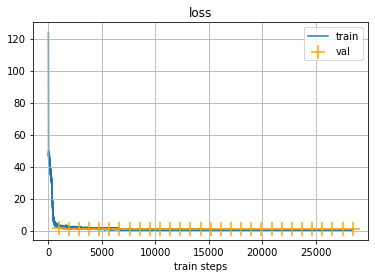

CER score


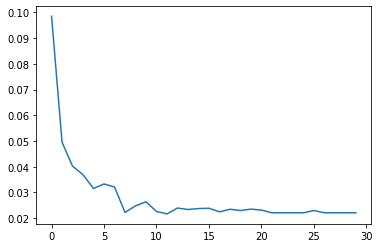

Mean levenshtein score


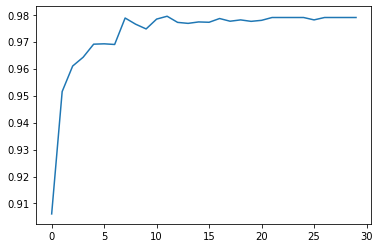

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

print(model_name)
best_cer = np.inf
best_lev = 0
best_loss = np.inf
best_epoch = 0
train_history = []
cer_history = []
val_history = []
mean_lev_history = []
#val_loop(val_loader, model, criterion, tokenizer, DEVICE)
for epoch in tqdm.tqdm_notebook(range(config_json['num_epochs'])):
    print("num of epoch", epoch)
    loss_avg, train_history = train_loop(train_loader, model, criterion, optimizer, epoch, train_history)
    print('average_train_loss', loss_avg)
    val_loss_avg, cer_avg, acc_avg, mean_lev_score = val_loop(val_loader, model, criterion, tokenizer, DEVICE)
    val_history.append(val_loss_avg)
    cer_history.append(cer_avg)
    mean_lev_history.append(mean_lev_score)
    scheduler.step(cer_avg)
    if mean_lev_score > best_lev:
        best_lev = mean_lev_score
        best_epoch = epoch
        best_loss = val_loss_avg
        model_save_path = os.path.join(
            config_json['save_dir'], f'{model_name}-{epoch}-{mean_lev_score:.4f}.ckpt')
        torch.save(model.state_dict(), model_save_path)
        print('Model weights saved')
    clear_output()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'{model_name}')
    print(f'Current CER = {cer_avg}')
    print(f'Current loss = {val_loss_avg}')
    print(f'Current acc_avg = {acc_avg}')
    print(f'Current learning rate = {lr}')
    print('-' * 20)
    print(f'Best CER = {best_cer}')
    print(f'Mean CER = {np.mean(cer_history)}')
    print(f'Current mean_lev_score = {mean_lev_score}')
    print(f'Mean mean_lev_history = {np.mean(mean_lev_history)}')
    print(f'Max mean_lev_history = {np.max(mean_lev_history)}')
    print(f'Best loss = {best_loss}')
    print(f'Best epoch = {best_epoch}')
    plot_loss_history(train_history, val_history)
    print('CER score')
    plt.plot(cer_history)
    plt.show()
    print('Mean levenshtein score')
    plt.plot(mean_lev_history)
    plt.show()

## 10. Тестируем обученную модель

In [ ]:
use_gpu = False

if use_gpu:
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
model = CRNN_RESNET(tokenizer.get_num_chars(), 32)
model.load_state_dict(torch.load("/drive/My Drive/netology_hw/final_proj_2/recog_model/w_256_h_64_bs_256_ne_30_lr_0.001_ds_netology_final_proj_data-11-0.9794.ckpt", map_location = 'cpu'))
model.to(device)
model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

CRNN_RESNET(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
# Recovers the original `dataset` from the `dataloader`
dataset = val_loader.dataset
n_samples = len(dataset)
n_samples

1129

In [ ]:
item = 7
dataset[item]

(tensor([[[0.7461, 0.7461, 0.7461,  ..., 0.7461, 0.7461, 0.7461],
          [0.7461, 0.7461, 0.7461,  ..., 0.7461, 0.7461, 0.7461],
          [0.7461, 0.7461, 0.7461,  ..., 0.7461, 0.7461, 0.7461],
          ...,
          [0.7140, 0.7140, 0.7140,  ..., 0.6819, 0.7140, 0.7140],
          [0.7461, 0.7461, 0.7461,  ..., 0.7461, 0.7461, 0.7461],
          [0.7461, 0.7461, 0.7461,  ..., 0.7461, 0.7461, 0.7461]],
 
         [[0.7437, 0.7437, 0.7437,  ..., 0.7437, 0.7437, 0.7437],
          [0.7437, 0.7437, 0.7437,  ..., 0.7437, 0.7437, 0.7437],
          [0.7437, 0.7437, 0.7437,  ..., 0.7437, 0.7437, 0.7437],
          ...,
          [0.7118, 0.7118, 0.7118,  ..., 0.6799, 0.6959, 0.6959],
          [0.7437, 0.7437, 0.7437,  ..., 0.7437, 0.7437, 0.7437],
          [0.7437, 0.7437, 0.7437,  ..., 0.7437, 0.7437, 0.7437]],
 
         [[0.7502, 0.7502, 0.7502,  ..., 0.7502, 0.7502, 0.7502],
          [0.7502, 0.7502, 0.7502,  ..., 0.7502, 0.7502, 0.7502],
          [0.7502, 0.7502, 0.7502,  ...,

In [ ]:
%%time
text_preds, output, output2 = predict(dataset[item][0].unsqueeze(0), model, tokenizer, device, return_output=True)

CPU times: user 301 ms, sys: 845 µs, total: 302 ms
Wall time: 53.8 ms


In [ ]:
dataset[item][0].unsqueeze(0).shape

torch.Size([1, 3, 64, 256])

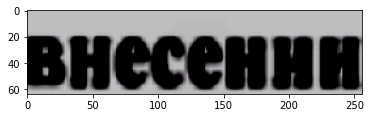

In [ ]:
item = 7
image = dataset[item][0].permute(1, 2, 0).numpy()
plt.imshow(image)
plt.show()

In [ ]:
text_preds

['внесении']